<a href="https://colab.research.google.com/github/AsadiAhmad/POS-Tagging/blob/main/Code/POS_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In [69]:
import requests
import zipfile
import os

import polars as pl
import numpy as np

import math
import re
import random

from typing import Dict, List, Tuple
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Get Corpus

## Download zip files

In [70]:
def download_zip(url, save_dir='.'):
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, url.split('/')[-1])
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        return filename
    else:
        print(f"Failed to fetch {url}. Status code: {response.status_code}")
        return None

In [71]:
train_url = "https://raw.githubusercontent.com/AsadiAhmad/POS-Tagging/main/Dataset/train.zip"
test_url = "https://raw.githubusercontent.com/AsadiAhmad/POS-Tagging/main/Dataset/test.zip"

train_zip = download_zip(train_url)
test_zip = download_zip(test_url)

## Extrect Zip files

In [72]:
!unzip -o /content/train.zip -d /content

Archive:  /content/train.zip
  inflating: /content/train.txt      


In [73]:
!unzip -o /content/test.zip -d /content

Archive:  /content/test.zip
  inflating: /content/test.txt       


## Read the zip files

In [74]:
with open("train.txt", "r", encoding="utf-8") as file:
    train_txt = file.read()

with open("test.txt", "r", encoding="utf-8") as file:
    test_txt = file.read()

# Step 3: Convert Corpus to Polars Data frame

## Convert into polars

In [75]:
def Convert_to_Polars(text, is_test=False):
    lines = text.strip().split("\n")
    sentences = []
    tags = [] if not is_test else None
    current_sentence = []
    current_tags = [] if not is_test else None

    for line in lines:
        parts = line.split()
        if is_test:
            if len(parts) >= 1:
                word = parts[0]
                if word == "#":
                    if current_sentence:
                        sentences.append(current_sentence)
                        current_sentence = []
                else:
                    current_sentence.append(word)
        else:
            if len(parts) == 2:
                word, tag = parts
                if word == "#":
                    if current_sentence:
                        sentences.append(current_sentence)
                        tags.append(current_tags)
                        current_sentence = []
                        current_tags = []
                else:
                    current_sentence.append(word)
                    current_tags.append(tag)

    if current_sentence:
        sentences.append(current_sentence)
        if not is_test:
            tags.append(current_tags)

    if is_test:
        sentences = pl.DataFrame({
            "index": list(range(len(sentences))),
            "sentence": sentences
        })
    else:
        sentences = pl.DataFrame({
            "index": list(range(len(sentences))),
            "sentence": sentences,
            "tag": tags
        })

    return sentences

In [76]:
train_sentences = Convert_to_Polars(train_txt)
test_sentences = Convert_to_Polars(test_txt, True)

## Set Config for polar showing

In [77]:
pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(70)
pl.Config.set_fmt_table_cell_list_len(10)

polars.config.Config

## Showing frames

In [78]:
train_sentences.head(10)

index,sentence,tag
i64,list[str],list[str]
0,"[""اولین"", ""سیاره"", ""خارج"", ""از"", ""منظومه"", ""شمسی"", ""دیده"", ""شد"", "".""]","[""ADJ_SUP"", ""N_SING"", ""ADJ_SIM"", ""P"", ""N_SING"", ""ADJ_SIM"", ""ADJ_INO"", ""V_PA"", ""DELM""]"
1,"[""واشنگتن"", ""ـ"", ""خبرگزاری"", ""جمهوری"", ""اسلامی""]","[""N_SING"", ""DELM"", ""N_SING"", ""N_SING"", ""ADJ_SIM""]"
2,"[""ستاره‌شناسان"", ""می‌گویند"", ""که"", ""ممکن"", ""است"", ""اولین"", ""سیاره"", ""خارج"", ""از"", … "".""]","[""N_PL"", ""V_PRS"", ""CON"", ""ADJ_SIM"", ""V_PRE"", ""ADJ_SUP"", ""N_SING"", ""ADJ_SIM"", ""P"", … ""DELM""]"
3,"[""دمشق"", ""،"", ""واحد"", ""مرکزی"", ""خبر""]","[""N_SING"", ""DEFAULT"", ""N_SING"", ""ADJ_SIM"", ""N_SING""]"
4,"[""مصرف"", ""مداوم"", ""موز"", ""می‌تواند"", ""به"", ""مشکلات"", ""دستگاه"", ""گوارش"", ""و"", … "".""]","[""N_SING"", ""ADJ_SIM"", ""N_SING"", ""V_PRS"", ""P"", ""N_PL"", ""N_SING"", ""N_SING"", ""CON"", … ""DELM""]"
5,"[""تهران"", ""ـ"", ""واحد"", ""مرکزی"", ""خبر""]","[""N_SING"", ""DELM"", ""N_SING"", ""ADJ_SIM"", ""N_SING""]"
6,"[""استفاده"", ""از"", ""بالش‌های"", ""پر"", ""برای"", ""بیماران"", ""مبتلا"", ""به"", ""آسم"", … "".""]","[""N_SING"", ""P"", ""N_PL"", ""ADJ_SIM"", ""P"", ""N_PL"", ""ADJ_SIM"", ""P"", ""N_SING"", … ""DELM""]"
7,"[""مسعود"", ""شجاعی"", ""طباطبایی""]","[""N_SING"", ""N_SING"", ""N_SING""]"
8,"[""دنیای"", ""آدولف"", ""بورن"", ""دنیای"", ""اتفاقات"", ""رویایی"", ""است"", ""."", ""برای"", … "".""]","[""N_SING"", ""N_SING"", ""N_SING"", ""N_SING"", ""N_PL"", ""ADJ_SIM"", ""V_PRE"", ""DELM"", ""P"", … ""DELM""]"


In [79]:
test_sentences.head(10)

index,sentence
i64,list[str]
0,"[""در"", ""مناطق"", ""دور‌دست"", ""و"", ""مناطقی"", ""که"", ""100"", ""کیلومتر"", ""تا"", … "".""]"
1,"[""بحث"", ""اول""]"
2,"[""بحث"", ""در"", ""مورد"", ""یادبودی"", ""برای"", ""قربانیان"", ""کشتار"", ""دسته‌جمعی"", ""در"", ""برلین""]"
3,"[""بحث"", ""دوم""]"
4,"[""بحث"", ""در"", ""مورد"", ""کتاب"", """""", ""دانیال"", ""کلدخاگن"", """""", ""در"", … "".""]"
5,"[""بحث"", ""سوم"", "":"", ""نبرد"", ""مبرم"", ""در"", ""مورد"", ""نمایشگاهی"", ""که"", … "".""]"
6,"[""کتاب"", ""تاریخ"", ""اسرائیل"", ""نوشته"", ""موش"", ""سوکرمان"", ""در"", ""سال"", ""1998"", … "".""]"
7,"[""گستاخی"", ""تؤتر""]"
8,"[""هنرنمایی"", ""روبرت"", ""کولی"", ""در"", ""تهران"", ""مباحثی"", ""پرجنب‌وجوش"", ""را"", ""در"", … "".""]"


# Step 4: Split Train set into Train and Validation set

In [11]:
validation_sentences = train_sentences.sample(fraction=0.1, shuffle=True)
train_sentences = train_sentences.join(validation_sentences, on=train_sentences.columns, how="anti")

In [12]:
train_sentences = train_sentences.with_columns(pl.arange(0, train_sentences.height).alias("index"))
validation_sentences = validation_sentences.with_columns(pl.arange(0, validation_sentences.height).alias("index"))

In [13]:
train_sentences.head(10)

index,sentence,tag
i64,list[str],list[str]
0,"[""اولین"", ""سیاره"", ""خارج"", ""از"", ""منظومه"", ""شمسی"", ""دیده"", ""شد"", "".""]","[""ADJ_SUP"", ""N_SING"", ""ADJ_SIM"", ""P"", ""N_SING"", ""ADJ_SIM"", ""ADJ_INO"", ""V_PA"", ""DELM""]"
1,"[""واشنگتن"", ""ـ"", ""خبرگزاری"", ""جمهوری"", ""اسلامی""]","[""N_SING"", ""DELM"", ""N_SING"", ""N_SING"", ""ADJ_SIM""]"
2,"[""ستاره‌شناسان"", ""می‌گویند"", ""که"", ""ممکن"", ""است"", ""اولین"", ""سیاره"", ""خارج"", ""از"", … "".""]","[""N_PL"", ""V_PRS"", ""CON"", ""ADJ_SIM"", ""V_PRE"", ""ADJ_SUP"", ""N_SING"", ""ADJ_SIM"", ""P"", … ""DELM""]"
3,"[""دمشق"", ""،"", ""واحد"", ""مرکزی"", ""خبر""]","[""N_SING"", ""DEFAULT"", ""N_SING"", ""ADJ_SIM"", ""N_SING""]"
4,"[""مصرف"", ""مداوم"", ""موز"", ""می‌تواند"", ""به"", ""مشکلات"", ""دستگاه"", ""گوارش"", ""و"", … "".""]","[""N_SING"", ""ADJ_SIM"", ""N_SING"", ""V_PRS"", ""P"", ""N_PL"", ""N_SING"", ""N_SING"", ""CON"", … ""DELM""]"
5,"[""تهران"", ""ـ"", ""واحد"", ""مرکزی"", ""خبر""]","[""N_SING"", ""DELM"", ""N_SING"", ""ADJ_SIM"", ""N_SING""]"
6,"[""استفاده"", ""از"", ""بالش‌های"", ""پر"", ""برای"", ""بیماران"", ""مبتلا"", ""به"", ""آسم"", … "".""]","[""N_SING"", ""P"", ""N_PL"", ""ADJ_SIM"", ""P"", ""N_PL"", ""ADJ_SIM"", ""P"", ""N_SING"", … ""DELM""]"
7,"[""دنیای"", ""آدولف"", ""بورن"", ""دنیای"", ""اتفاقات"", ""رویایی"", ""است"", ""."", ""برای"", … "".""]","[""N_SING"", ""N_SING"", ""N_SING"", ""N_SING"", ""N_PL"", ""ADJ_SIM"", ""V_PRE"", ""DELM"", ""P"", … ""DELM""]"
8,"[""فیلمنامه"", ""کوتاه"", ""وسوسه""]","[""N_SING"", ""ADJ_SIM"", ""N_SING""]"


In [14]:
validation_sentences.head(10)

index,sentence,tag
i64,list[str],list[str]
0,"[""ازدواج"", ""پس"", ""از"", ""46"", ""سال"", ""انتظار"", ""!""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_SING"", ""N_SING"", ""DELM""]"
1,"[""پاریس"", ""ـ"", ""ایرنا""]","[""N_SING"", ""DELM"", ""N_SING""]"
2,"[""الفبای"", ""فارسی"", ""باستان"", ""36"", ""حرف"", ""و"", ""2"", ""واژه‌جداکن"", ""و"", … "".""]","[""N_SING"", ""N_SING"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""CON"", ""N_SING"", ""N_SING"", ""CON"", … ""DELM""]"
3,"[""نیویورک"", ""-"", ""ایرنا"", "":"", ""مقامات"", ""بهداشتی"", ""آمریکا"", ""اعلام"", ""کردند"", … "".""]","[""N_SING"", ""DELM"", ""N_SING"", ""DELM"", ""N_PL"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""V_PA"", … ""DELM""]"
4,"[""مسعود"", ""جمشیدی"", "":"", ""همه"", ""تلاش"", ""خود"", ""را"", ""به"", ""کار"", … "".""]","[""N_SING"", ""N_SING"", ""DELM"", ""QUA"", ""N_SING"", ""PRO"", ""P"", ""P"", ""N_SING"", … ""DELM""]"
5,"[""روزنامه"", ""ایران"", ""در"", ""ستون"", ""خبرهای"", ""ویژه"", ""خود"", ""نوشته"", ""است"", … "".""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_PL"", ""ADJ_SIM"", ""PRO"", ""ADJ_INO"", ""V_PRE"", … ""DELM""]"
6,"[""نیروهای"", ""روسیه"", ""،"", ""دیروز"", ""»"", ""شنبه"", ""«"", ""برای"", ""دومین"", … "".""]","[""N_PL"", ""N_SING"", ""DELM"", ""ADV_TIME"", ""DELM"", ""N_SING"", ""DELM"", ""P"", ""ADJ_SUP"", … ""DELM""]"
7,"[""یک"", ""زن"", ""جوان"", ""آلمانی"", ""که"", ""برای"", ""گردش"", ""به"", ""ترکیه"", … "".""]","[""N_SING"", ""N_SING"", ""ADJ_SIM"", ""ADJ_SIM"", ""CON"", ""P"", ""N_SING"", ""P"", ""N_SING"", … ""DELM""]"
8,"[""نگارنده"", ""بحث"", ""ساخت"", ""سازه‌ای"", ""گروه"", ""فعلی"", ""و"", ""این‌که"", ""وابسته‌ها"", … "".""]","[""N_SING"", ""N_SING"", ""N_SING"", ""ADJ_SIM"", ""N_SING"", ""ADJ_SIM"", ""CON"", ""CON"", ""N_PL"", … ""DELM""]"


# Step 5: Preprocessing

In [15]:
# Actually this train set is good enough for not preprocessing!

# Step 6: Calculate Emission Model

In [16]:
def calculate_emission_model(dataframe):
    model_dict = dict()
    tag_counts  = dict()
    for row in dataframe.rows(named=True):
        for index in range(len(row["sentence"])):
            word = row["sentence"][index]
            tag = row["tag"][index]
            if (word, tag) in model_dict:
                model_dict[(word, tag)] += 1
            else:
                model_dict[(word, tag)] = 1
            if tag in tag_counts:
                tag_counts[tag] += 1
            else:
                tag_counts[tag] = 1

    for (word, tag), count in model_dict.items():
        model_dict[(word, tag)] = count / tag_counts[tag]

    return model_dict

In [17]:
emission_model_dict = calculate_emission_model(train_sentences)

# Step 7: Calculate N-Gram Model

In [18]:
def calculate_ngram_probabilities(df: pl.DataFrame, n: int) -> Dict[Tuple[str, ...], float]:
    ngram_counts = defaultdict(int)
    total_ngrams = 0

    for sentence in df['tag']:
        for i in range(len(sentence) - n + 1):
            ngram = tuple(sentence[i:i+n])
            ngram_counts[ngram] += 1
            total_ngrams += 1

    ngram_probabilities = {ngram: count / total_ngrams for ngram, count in ngram_counts.items()}

    return ngram_probabilities

In [19]:
unigram_dict = calculate_ngram_probabilities(train_sentences, n=1)
bigram_dict = calculate_ngram_probabilities(train_sentences, n=2)
trigram_dict = calculate_ngram_probabilities(train_sentences, n=3)

In [20]:
def get_random_ngram_sample(ngram_dict: dict, k: int = 1) -> dict:
    if not ngram_dict:
        return {}

    keys = random.sample(list(ngram_dict.keys()), k)
    return {key: ngram_dict[key] for key in keys}

In [21]:
get_random_ngram_sample(trigram_dict)

{('N_PL', 'ADJ_SIM', 'N_PL'): 0.0006347359114604392}

# Step 8: Viterbi Algorithm

In [22]:
def viterbi_part(word_part, tag_part, n, emission_model_dict, unigram_dict, bigram_dict, trigram_dict):
    last_word = word_part[-1]
    if last_word == '.':
        return "DELM"

    possible_tags = list(unigram_dict.keys())
    best_tag = "UNK"
    best_log_prob = -float('inf')

    if n == 1 and len(tag_part) == 0:
        for tag in possible_tags:
            current_tag = tag[0] if isinstance(tag, tuple) else tag
            P_word_given_tag = emission_model_dict.get((last_word, current_tag), 0)
            if P_word_given_tag <= 0:
                if last_word.startswith("می‌"):
                    P_word_given_tag = emission_model_dict.get(("می‌*", current_tag), 0)
                elif last_word.endswith("ها"):
                    P_word_given_tag = emission_model_dict.get(("*ها", current_tag), 0)

            if P_word_given_tag <= 0:
                continue

            P_tag = unigram_dict.get(current_tag, 0)
            if P_tag <= 0:
                continue

            log_prob = math.log(P_word_given_tag) + math.log(P_tag)

            if log_prob > best_log_prob:
                best_log_prob = log_prob
                best_tag = current_tag

    else:
        for tag in possible_tags:
            current_tag = tag[0] if isinstance(tag, tuple) else tag
            P_word_given_tag = emission_model_dict.get((last_word, current_tag), 0)
            if P_word_given_tag <= 0:
                continue

            log_P_word = math.log(P_word_given_tag)
            log_P_transition = -float('inf')

            if n == 1:
                P_tag = unigram_dict.get(current_tag, 0)
                if P_tag > 0:
                    log_P_transition = math.log(P_tag)

            elif n == 2 and len(tag_part) >= 1:
                prev_tag = tag_part[-1][0] if isinstance(tag_part[-1], tuple) else tag_part[-1]
                P_trans = bigram_dict.get((prev_tag, current_tag), 0)
                if P_trans > 0:
                    log_P_transition = math.log(P_trans)

            elif n == 3 and len(tag_part) >= 2:
                prev1 = tag_part[-1][0] if isinstance(tag_part[-1], tuple) else tag_part[-1]
                prev2 = tag_part[-2][0] if isinstance(tag_part[-2], tuple) else tag_part[-2]
                P_trans = trigram_dict.get((prev2, prev1, current_tag), 0)
                if P_trans > 0:
                    log_P_transition = math.log(P_trans)

            if log_P_transition == -float('inf'):
                continue
            total_log_prob = log_P_word + log_P_transition

            if total_log_prob > best_log_prob:
                best_log_prob = total_log_prob
                best_tag = current_tag

    if best_tag == "UNK" and len(possible_tags) > 0:
        best_tag = max(unigram_dict.items(), key=lambda x: x[1])[0]
        if isinstance(best_tag, tuple):
            best_tag = best_tag[0]

    return best_tag

In [23]:
tag = viterbi_part(["ستاره‌شناسان", "می‌گویند", "که"], ["N_PL", "V_PRS"], 3, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)

In [24]:
print(tag)

CON


In [25]:
def viterbi_sentence(sentence, n, emission_model_dict, unigram_dict, bigram_dict, trigram_dict):
    tag_sequence = []

    for i, word in enumerate(sentence):
        if i == 0:
            tag_n = 1
        elif i == 1:
            tag_n = min(n, 2)
        else:
            tag_n = n
        best_tag = viterbi_part(sentence[:i+1], tag_sequence, tag_n, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)
        tag_sequence.append(best_tag)

    return tag_sequence

In [26]:
sentunce = viterbi_sentence(["اولین", "سیاره", "خارج", "از", "منظومه", "شمسی"], 3, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)

In [27]:
print(sentunce)

['N_SING', 'N_SING', 'N_SING', 'P', 'N_SING', 'ADJ_SIM']


In [28]:
def calculate_viterbi(validation_sentences, n, emission_model_dict, unigram_dict, bigram_dict, trigram_dict):
    validation_sentences = validation_sentences.with_columns(
        pl.col("sentence").map_elements(
            lambda sentence: viterbi_sentence(sentence, n, emission_model_dict, unigram_dict, bigram_dict, trigram_dict),
            return_dtype=pl.List(pl.String)
        ).alias("predicted_tag")
    )

    return validation_sentences

In [60]:
validation_sentences_unigram = calculate_viterbi(validation_sentences, 1, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)
validation_sentences_bigram = calculate_viterbi(validation_sentences, 2, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)
validation_sentences_trigram = calculate_viterbi(validation_sentences, 3, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)

In [30]:
validation_sentences.head(10)

index,sentence,tag,predicted_tag
i64,list[str],list[str],list[str]
0,"[""ازدواج"", ""پس"", ""از"", ""46"", ""سال"", ""انتظار"", ""!""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_SING"", ""N_SING"", ""DELM""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_SING"", ""N_SING"", ""DELM""]"
1,"[""پاریس"", ""ـ"", ""ایرنا""]","[""N_SING"", ""DELM"", ""N_SING""]","[""N_SING"", ""DELM"", ""N_SING""]"
2,"[""الفبای"", ""فارسی"", ""باستان"", ""36"", ""حرف"", ""و"", ""2"", ""واژه‌جداکن"", ""و"", … "".""]","[""N_SING"", ""N_SING"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""CON"", ""N_SING"", ""N_SING"", ""CON"", … ""DELM""]","[""N_SING"", ""ADJ_SIM"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""CON"", ""N_SING"", ""N_SING"", ""CON"", … ""DELM""]"
3,"[""نیویورک"", ""-"", ""ایرنا"", "":"", ""مقامات"", ""بهداشتی"", ""آمریکا"", ""اعلام"", ""کردند"", … "".""]","[""N_SING"", ""DELM"", ""N_SING"", ""DELM"", ""N_PL"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""V_PA"", … ""DELM""]","[""N_SING"", ""DELM"", ""N_SING"", ""DELM"", ""N_PL"", ""ADJ_SIM"", ""N_SING"", ""N_SING"", ""V_PA"", … ""DELM""]"
4,"[""مسعود"", ""جمشیدی"", "":"", ""همه"", ""تلاش"", ""خود"", ""را"", ""به"", ""کار"", … "".""]","[""N_SING"", ""N_SING"", ""DELM"", ""QUA"", ""N_SING"", ""PRO"", ""P"", ""P"", ""N_SING"", … ""DELM""]","[""N_SING"", ""N_SING"", ""DELM"", ""QUA"", ""N_SING"", ""PRO"", ""P"", ""P"", ""N_SING"", … ""DELM""]"
5,"[""روزنامه"", ""ایران"", ""در"", ""ستون"", ""خبرهای"", ""ویژه"", ""خود"", ""نوشته"", ""است"", … "".""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_PL"", ""ADJ_SIM"", ""PRO"", ""ADJ_INO"", ""V_PRE"", … ""DELM""]","[""N_SING"", ""N_SING"", ""P"", ""N_SING"", ""N_PL"", ""ADJ_SIM"", ""PRO"", ""ADJ_INO"", ""V_PRE"", … ""DELM""]"
6,"[""نیروهای"", ""روسیه"", ""،"", ""دیروز"", ""»"", ""شنبه"", ""«"", ""برای"", ""دومین"", … "".""]","[""N_PL"", ""N_SING"", ""DELM"", ""ADV_TIME"", ""DELM"", ""N_SING"", ""DELM"", ""P"", ""ADJ_SUP"", … ""DELM""]","[""N_SING"", ""N_SING"", ""DELM"", ""ADV_TIME"", ""DELM"", ""N_SING"", ""DELM"", ""P"", ""ADJ_SUP"", … ""DELM""]"
7,"[""یک"", ""زن"", ""جوان"", ""آلمانی"", ""که"", ""برای"", ""گردش"", ""به"", ""ترکیه"", … "".""]","[""N_SING"", ""N_SING"", ""ADJ_SIM"", ""ADJ_SIM"", ""CON"", ""P"", ""N_SING"", ""P"", ""N_SING"", … ""DELM""]","[""N_SING"", ""N_SING"", ""ADJ_SIM"", ""ADJ_SIM"", ""CON"", ""P"", ""N_SING"", ""P"", ""N_SING"", … ""DELM""]"
8,"[""نگارنده"", ""بحث"", ""ساخت"", ""سازه‌ای"", ""گروه"", ""فعلی"", ""و"", ""این‌که"", ""وابسته‌ها"", … "".""]","[""N_SING"", ""N_SING"", ""N_SING"", ""ADJ_SIM"", ""N_SING"", ""ADJ_SIM"", ""CON"", ""CON"", ""N_PL"", … ""DELM""]","[""N_SING"", ""N_SING"", ""N_SING"", ""ADJ_SIM"", ""N_SING"", ""ADJ_SIM"", ""CON"", ""CON"", ""N_PL"", … ""DELM""]"


# Step 9: Calculate Confusion Matrix

In [41]:
def calculate_confusion_metrics(dataframe: pl.DataFrame) -> Dict[str, int]:
    metrics = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}

    for row in dataframe.iter_rows(named=True):
        true_tags = row['tag']
        predicted_tags = row['predicted_tag']

        for true_tag, pred_tag in zip(true_tags, predicted_tags):
            if true_tag == pred_tag:
                metrics['TP'] += 1
            else:
                metrics['FP'] += 1
                metrics['FN'] += 1

    metrics['TN'] = 0

    return metrics

In [61]:
metrics_unigram = calculate_confusion_metrics(validation_sentences_unigram)
metrics_bigram = calculate_confusion_metrics(validation_sentences_bigram)
metrics_trigram = calculate_confusion_metrics(validation_sentences_trigram)

In [58]:
def plot_confusion_matrix_seaborn(tp, fp, fn, tn, title='Confusion Matrix'):
    cm = np.array([[tp, fp], [fn, tn]])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted +', 'Predicted -'],
                yticklabels=['Actual +', 'Actual -'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

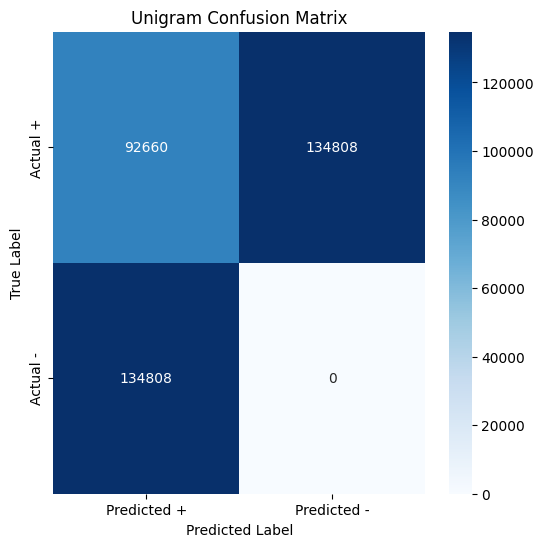

In [62]:
plot_confusion_matrix_seaborn(metrics_unigram['TP'], metrics_unigram['FP'], metrics_unigram['FN'], metrics_unigram['TN'], "Unigram Confusion Matrix")

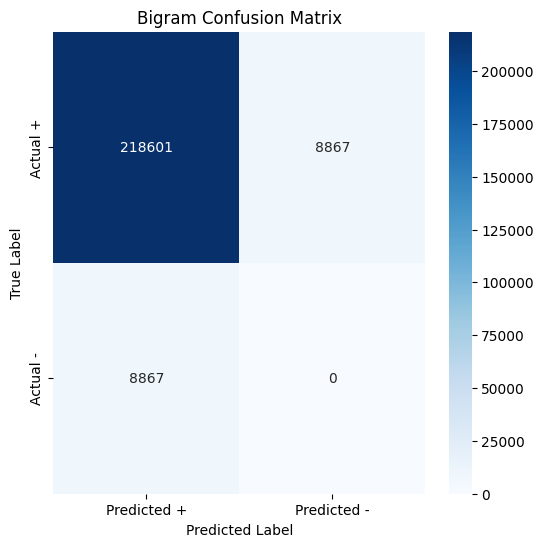

In [63]:
plot_confusion_matrix_seaborn(metrics_bigram['TP'], metrics_bigram['FP'], metrics_bigram['FN'], metrics_bigram['TN'], "Bigram Confusion Matrix")

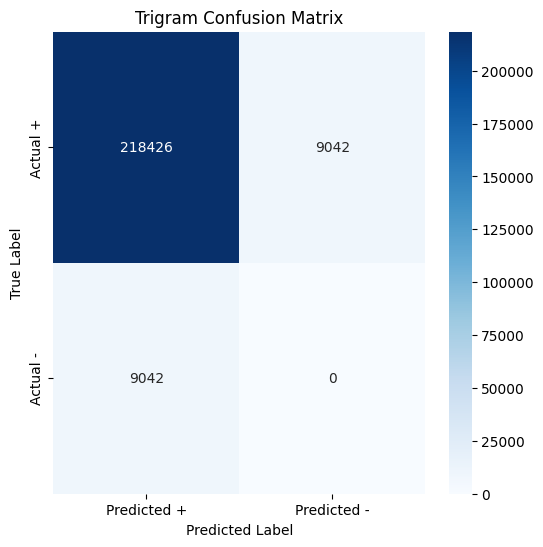

In [64]:
plot_confusion_matrix_seaborn(metrics_trigram['TP'], metrics_trigram['FP'], metrics_trigram['FN'], metrics_trigram['TN'], "Trigram Confusion Matrix")

# Step 10: Calculate Measurements

In [51]:
def calculate_measurements(tp: int, fp: int, fn: int, tn: int) -> Tuple[float, float, float, float]:
    accuracy = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return accuracy, precision, recall, f1

In [65]:
measurements_unigram = calculate_measurements(metrics_unigram['TP'], metrics_unigram['FP'], metrics_unigram['FN'], metrics_unigram['TN'])
measurements_bigram = calculate_measurements(metrics_bigram['TP'], metrics_bigram['FP'], metrics_bigram['FN'], metrics_bigram['TN'])
measurements_trigram = calculate_measurements(metrics_trigram['TP'], metrics_trigram['FP'], metrics_trigram['FN'], metrics_trigram['TN'])

In [53]:
def print_measurements(accuracy, precision, recall, f1):
    print(f"Accuracy: {accuracy*100:.4f}")
    print(f"Precision: {precision*100:.4f}")
    print(f"Recall: {recall*100:.4f}")
    print(f"F1-score: {f1*100:.4f}")

In [66]:
print_measurements(measurements_unigram[0], measurements_unigram[1], measurements_unigram[2], measurements_unigram[3])

Accuracy: 25.5772
Precision: 40.7354
Recall: 40.7354
F1-score: 40.7354


In [67]:
print_measurements(measurements_bigram[0], measurements_bigram[1], measurements_bigram[2], measurements_bigram[3])

Accuracy: 92.4962
Precision: 96.1019
Recall: 96.1019
F1-score: 96.1019


In [68]:
print_measurements(measurements_trigram[0], measurements_trigram[1], measurements_trigram[2], measurements_trigram[3])

Accuracy: 92.3538
Precision: 96.0249
Recall: 96.0249
F1-score: 96.0249


# Step 11: Calculate the test set

In [81]:
tagged_test = calculate_viterbi(test_sentences, 2, emission_model_dict, unigram_dict, bigram_dict, trigram_dict)

In [86]:
test_list_tags = []
for row in tagged_test.iter_rows(named=True):
    the_list = row["predicted_tag"]
    for element in the_list:
        test_list_tags.append(element)

In [87]:
def add_tags_to_file(input_file, tags, output_file, delimiter_tag="DELM"):
    with open(input_file, 'r') as f:
        words = [line.strip() for line in f.readlines()]

    tag_index = 0
    output_lines = []

    for word in words:
        if word == '#':
            output_lines.append(f"#\t{delimiter_tag}")
        else:
            if tag_index < len(tags):
                output_lines.append(f"{word}\t{tags[tag_index]}")
                tag_index += 1
            else:
                output_lines.append(f"{word}\tNO_TAG")

    with open(output_file, 'w') as f:
        f.write('\n'.join(output_lines))

In [88]:
add_tags_to_file("/content/test.txt", test_list_tags, "/content/test_notags.txt", delimiter_tag="DELM")